## Identify major breaking news events

**Idea**:
The basic idea of tackle this problem is to do the **clustering problem**. Before that, I should do some data cleaning and tokenization work.

Pipeline:
- Load the data set
- Clean the text: tokenization, remove stopwords and punctuation
- Extract the features (TF-IDF, word vectors)
- Clustering
- Output the results.

We only use the `ArticleTitle` in this part.

To save time, the data set used in this notebook is shortten by the original data set.

(or you can choose when you the original one. The last time when I was testing my notebook, I used the original data set. )

### Load the Data Set

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_type = {'ArticleId': 'str',
             'ArticleURL': 'str',
             'ArticleTitle': 'str',
             'ArticleDescription': 'str',
             'ArticlePublishedTime': 'int'}
# df = pd.read_excel("data/data_news_shorten.xlsx", dtype=data_type)[['ArticleTitle']]
df = pd.read_excel("data/data_news.xlsx", dtype=data_type)[['ArticleTitle']]
df.head()

,ArticleTitle
0,Lowestoft sea wall fall cyclist rescued by friend
1,The Met Gala & ‘Game of Thrones’ Feature in Th...
2,Boy dies on prom day after allergic reaction t...
3,Paddy Jackson’s return to Rugby is yet more pr...
4,BAFTA TV Awards 2019: Stars prepare for glitzy...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13022 entries, 0 to 13021
Data columns (total 1 columns):
ArticleTitle    13022 non-null object
dtypes: object(1)
memory usage: 101.8+ KB


### Clean the Text

- lower case and tokenize 
- Remove stopwords and punctuations

In [10]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

list_of_stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)

In [7]:
def remove_stopwords_punc(tokenizedSentence):
    '''
    Remove the stops words and punctuation
    args:
        tokenizedSentence: the sentence which has been tokenized into words.
    returns:
        list of words without stopwords and punctuations, the word less than 2 letters are also deleted
    '''
    word_tokenized_without_stop_punc = []
    for word in tokenizedSentence:
        if (word not in list_of_stop_words) and (word not in punctuations) and (len(word)>2):
            word_tokenized_without_stop_punc.append(word)
    return word_tokenized_without_stop_punc

def strip_symbols_number(sentence):
    '''
    Remove all symbol characters and the number combination(like 100th).
    
    Since the previous `remove_stopwords_punc` is not very effective to get rid of the symbols and some combination. 
    `re` module is used here.
    '''
    s=re.sub(r'[^\w\s]', ' ', sentence)
    s=re.sub(r'([A-Za-z]+[\d]+[\w]*|[\d]+[A-Za-z]+[\w]*)|[\d]',' ',s)
    return s


In [11]:
%%time
# Clean the text and tokenize
df['Words_Tokenized']=''
for index,content in df.iterrows():
    sentence=content['ArticleTitle'].lower()
    s=strip_symbols_number(sentence)
    token_list=word_tokenize(s)
    words_list=remove_stopwords_punc(token_list)
    df.loc[index,'Words_Tokenized']=words_list

CPU times: user 23 s, sys: 19.1 ms, total: 23 s
Wall time: 23 s


In [12]:
df.head()

# --- The next several line codes in this cell is to generate corpus for training doc2vec.
# See `3. Further Idea.ipynb`. ----

# df_doc2vec=df.copy()
# for index,content in df_doc2vec.iterrows():
#     df_doc2vec.loc[index,'Words_Tokenized']=' '.join(content['Words_Tokenized'])
# df_doc2vec[['Words_Tokenized']].to_csv('data/news_corpus_for_doc2vec.csv',index=False)

,ArticleTitle,Words_Tokenized
0,Lowestoft sea wall fall cyclist rescued by friend,"[lowestoft, sea, wall, fall, cyclist, rescued,..."
1,The Met Gala & ‘Game of Thrones’ Feature in Th...,"[met, gala, game, thrones, feature, week, top,..."
2,Boy dies on prom day after allergic reaction t...,"[boy, dies, prom, day, allergic, reaction, pol..."
3,Paddy Jackson’s return to Rugby is yet more pr...,"[paddy, jackson, return, rugby, yet, proof, mi..."
4,BAFTA TV Awards 2019: Stars prepare for glitzy...,"[bafta, awards, stars, prepare, glitzy, ceremo..."


### Extract Features
There are several ways to extract the features.
- TF/TF-IDF
- word vectors

#### Extract the TF-IDF Feature

In [13]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
%%time 

corpus4tfidf=[' '.join(content['Words_Tokenized']) for index,content in df.iterrows()]

vectorizer = CountVectorizer()  
transformer = TfidfTransformer()  

tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus4tfidf))
vocab_tfidf = vectorizer.get_feature_names()  
weight_tfidf = tfidf.toarray()  

CPU times: user 2.42 s, sys: 530 ms, total: 2.95 s
Wall time: 2.77 s


In [15]:
%%time

transformer_tf = TfidfTransformer(use_idf=False)
tf=transformer_tf.fit_transform(vectorizer.fit_transform(corpus4tfidf))
weight_tf=tf.toarray()

CPU times: user 404 ms, sys: 436 ms, total: 840 ms
Wall time: 836 ms


In [16]:
weight_tfidf.shape

(13022, 18994)

By here, I found two problems:
- there are some non-english words in the `vocab_tfidf`
- The title is short, causing the sparse matrix. The sparse matrix isn't helpful for the distance calculation.

Therefore, I didn't use `tf-idf` anymore in this notebook. Word vector trained by `spacy` will be adopted in the next part.

#### Embedding the Title Sentences 

`gensim` supplied the `word2vec` and `doc2vec` models to embedding the sentences.

I found `spaCy` module by accident and wanna try this module here. 

There are many APIs that I can use, to find the details in https://spacy.io/api/doc.

In [18]:
# ! pip install spacy
# ! python -m spacy download en_core_web_sm
# ! python -m spacy link en_core_web_sm en_core_web_sm

Before using spacy, you may need to run the above cell to download the pre-trained model

In [19]:
import spacy
from tqdm import tqdm

In [20]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
# See the details of this model on https://spacy.io/models/en

By loading the pre-trained model, you can use it directly. Using `doc.vector` can get the vector of sentence directly.

In [21]:
%%time 

sent_vecs={}
docs=[]
for title in tqdm(df['ArticleTitle']):
    doc=nlp(title)
#     print(title)
    docs.append(doc)
    sent_vecs.update({title:doc.vector})

# You can save some time if you use the shorten data set.

100%|██████████| 13022/13022 [01:45<00:00, 123.17it/s]

CPU times: user 14min 3s, sys: 1.56 s, total: 14min 4s
Wall time: 1min 45s


In [22]:
%%time
sentences=list(sent_vecs.keys())
sentence_vectors=list(sent_vecs.values())

CPU times: user 1.62 ms, sys: 3 ms, total: 4.62 ms
Wall time: 4.61 ms


In [23]:
np.array(sentence_vectors).shape
# Here I use the shortten data set to for testing.

(13020, 384)

### Clustering 

There is no labels in the training data set, making it as a unsupervised learning problem. 

Since the number of cluster is dynamic, k-means is not suitable. 

`DESCAN` algorithm is used here to do the clustering. It is implemented by the `sklearn`.

Several key args in DBSCAN:
- `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other
- `min_samples`
- `metric`: measurement of the distance


In [25]:
import sklearn
from sklearn.cluster import DBSCAN
import scipy
import seaborn 
import matplotlib.pyplot as plt

#### Find the optimal `eps` value
How to set the `eps` value:
- try some title pairs (the given examples in the original specification docs) to get a primary understanding
- search among a `eps` interval and find the optimal one

[[0.         0.12841946 0.32963693 0.44018012 0.3596555 ]
 [0.12841946 0.         0.35830647 0.51902315 0.44068134]
 [0.32963693 0.35830647 0.         0.47020507 0.30675864]
 [0.44018012 0.51902315 0.47020507 0.         0.26348263]
 [0.3596555  0.44068134 0.30675864 0.26348263 0.        ]]


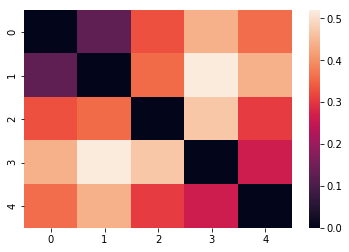

In [27]:
# First, test custom sentences list and get the distance matrix
# The sentences are selected from the original data set
sentence_pair = ["Novak Djokovic equals Rafael Nadal's ATP Masters 1000 record with win over Stefanos Tsitsipas in Madrid",
                 "Novak Djokovic eyes Paris after beating Stefanos Tsitsipas to win Madrid Open",
                "(Video) Watch Asamoah Gyan score twice to save Kayserispor from relegation",
                "Myanmar plane lands safely with no front wheels",
                "Smoke fills Myanmar plane after emergency landing without front wheel – video"]

docs_custom=[]
docs_custom_vectors=[]
for i in sentence_pair:
    doc_c=nlp(i)
#     print(i)
    docs_custom.append(doc_c)
    docs_custom_vectors.append(doc_c.vector)  

# Get the distance matrix 
distance_matrix_custom=np.ndarray((5,5))
for i in range(5):
    for j in range(5):
        distance_matrix_custom[i][j] = scipy.spatial.distance.cosine(docs_custom_vectors[i], docs_custom_vectors[j])
print(distance_matrix_custom)
seaborn.heatmap(distance_matrix_custom)

From the above matrix and heatmap, it turns out that the performance is okay. 

The 1st and 2nd is related to the same event, the 4th and 5th is the same event. And these two sentence pairs have the relative small distance.

It showed that it worth a try.

The best `eps` may be in [0.1,0.3]. 

Then I did **search** among [0.001,1]. By comparing the number of clusters, the optimal `eps` could be found.

In [28]:
# Get the vectors of sentences of the data set
x=np.array(sentence_vectors)

In [29]:
%%time 

# Search the best `eps`
# Can choose the shorten data set to save time. 
n_classes={}
for i in tqdm(np.arange(0.001,1,0.002)):
    dbscan=DBSCAN(eps=i,min_samples=2,metric='cosine').fit(x)
    n_classes.update({i:len(pd.Series(dbscan.labels_).value_counts())})
    

100%|██████████| 500/500 [25:34<00:00,  4.12s/it]


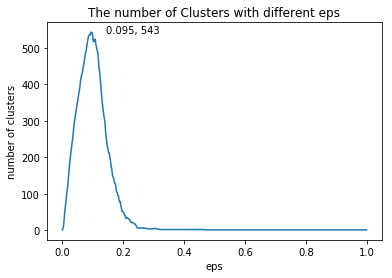

In [31]:
# Show the results of Search.
x_axis=list(n_classes.keys())
y_axis=list(n_classes.values())

y_max=np.max(y_axis)
index_max=y_axis.index(y_max)

seaborn.lineplot(x_axis,y_axis)
plt.title("The number of Clusters with different eps")
plt.xlabel("eps")
plt.ylabel("number of clusters")

# xlocs, xlabs = plt.xticks()
plt.text(x_axis[index_max]+0.05, y_max-3, str(x_axis[index_max])+", "+str(y_max))
plt.show()

It seems that the best `eps` is around 0.095. I would choose 0.095 as the `eps`.

In [34]:
dbscan=DBSCAN(eps=0.095,min_samples=2,metric='cosine').fit(x)

In [40]:
# See some examples from the results
results = pd.DataFrame({'label': dbscan.labels_, 'sentence': sentences})
example_result = results[results.label == 1]['sentence'].tolist()
print(example_result)

# df_all = pd.read_excel("data/data_news_shorten.xlsx", dtype=data_type)
df_all = pd.read_excel("data/data_news.xlsx", dtype=data_type)
event_df = df_all[df_all['ArticleTitle'].isin(example_result)][['ArticleURL', 'ArticleTitle', 'ArticleDescription', 'ArticlePublishedTime']]
event_df['ArticlePublishedTime'] = pd.to_datetime(event_df['ArticlePublishedTime'],unit='s')
event_df
#

['Boy dies on prom day after allergic reaction to pollen while celebrating GCSEs', 'Boy collapses and dies after suffering allergic reaction to pollen while celebrating end of GCSEs in park']


,ArticleURL,ArticleTitle,ArticleDescription,ArticlePublishedTime
2,https://www.mirror.co.uk/news/uk-news/boy-dies...,Boy dies on prom day after allergic reaction t...,Joe Dale's family have spoken out about losing...,2019-05-12 09:32:54
47,https://www.independent.co.uk/news/uk/home-new...,Boy collapses and dies after suffering allergi...,Parents speak out over 'heart-wrenching' loss ...,2019-05-12 09:47:12


From this example, it seems that the performance is okay. Let's see the count of the clusters.

In [41]:
# Group by the label and show the count of each label.
results.groupby('label').count()

,sentence
label,
-1,10467
0,1152
1,2
2,2
3,2
4,2
5,2
6,2
7,6


There are so many news articles labeled as -1. So the choice of `eps` is not just related to the number of clusters.

Should find better parameters to do the clustering.

### Label and Output the results

In [42]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13022 entries, 0 to 13021
Data columns (total 6 columns):
ArticleId               13022 non-null object
ArticleURL              13022 non-null object
ArticleTitle            13022 non-null object
ArticleDescription      9594 non-null object
ArticlePublishedTime    13022 non-null int64
EventId                 0 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 610.5+ KB


In [43]:
df_all['EventId']=results['label']

In [44]:
df_all.head()

,ArticleId,ArticleURL,ArticleTitle,ArticleDescription,ArticlePublishedTime,EventId
0,5cd7ed707ddacd3b2b3b549e,https://www.bbc.co.uk/news/uk-england-suffolk-...,Lowestoft sea wall fall cyclist rescued by friend,Coastguards praise the boy's friend for his ac...,1557653530,-1.0
1,5cd7e83beb96a44751294217,https://www.highsnobiety.com/p/met-gala-best-c...,The Met Gala & ‘Game of Thrones’ Feature in Th...,"Once again, our ever-sarcastic readership have...",1557653563,0.0
2,5cd7e99a8e662d1e4435cb3d,https://www.mirror.co.uk/news/uk-news/boy-dies...,Boy dies on prom day after allergic reaction t...,Joe Dale's family have spoken out about losing...,1557653574,1.0
3,5cd7f6dd7ddacd3b2b3b56ab,https://www.independent.co.uk/voices/paddy-jac...,Paddy Jackson’s return to Rugby is yet more pr...,He may have been found not guilty of rape last...,1557653588,-1.0
4,5cd7e89c8e662d1e4435cb13,https://www.standard.co.uk/showbiz/celebrity-n...,BAFTA TV Awards 2019: Stars prepare for glitzy...,Stars are preparing for Sunday night s TV Baft...,1557653610,-1.0


In [45]:
# df_all.to_csv("output/news_dataset_labeled_task1_shorten.csv",index=False)
df_all.to_csv("output/news_dataset_labeled_task1.csv",index=False)

### Summary 

In this part, I did the following work:
- Load the data set
- Clean the text: tokenization, remove stopwords and punctuation
- Extract the features (TF-IDF, word vectors)
- Clustering
- Output the results.

In the **text cleaning** part, I used `nltk` and `re` to clean. In the beginning, I only used `nltk`, but found the results not good. Then I import the `re`, used the regulation expression to get rid of the symbols and words combined with number.

In the **feature extraction** part, I first used the TF-IDF to extract the feature, but the matrix is too sparse that it couldn't be used in the distance calculation. Then I turned to get the word vectors, the basic idea is to use the average of words vectors as the sentence vector. `spacy` is used here, which I just found by accident recently.

To **clustered** the news related to the same event. It is basically a clustering problem in this task, but the data set is bigger and also need me to detect the non-breaking news. Since the number of the clusters is unknown. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is used here, `sklearn` is used to implement the algorithm.

---

The final output can cluster some relating news, but it can't tell whether the news articles are about major breaking news or not... 

This kind news (which should be labeled `-1`) can be seen as two kinds:
- Not telling the news happened in the current. It may be somebody's opinion on a general thing, like American dream, as the example showed.
- The breaking news which is is related to is not that popular and there are few news about this event.

For the first case, may be I should do classification before the clustering work. It needs the labelled data set to train the classifier.

For the second case, my current model can realize some part of it. The news which have less relation with other news haven't been clustered.

See the output file in the last code. I have generated two results for original data set and shorten data set respectively.